# Semantic Based-Regularization 

In this notebook, we will how to implement a simple example of SBR. 

### Example: 
We have a dataset of images containing triangles, squares, and circles, each with some noise.
We will first implement a baseline CNN model to predict the label of each image.
Next, we will compare its performance with a CNN enhanced by Semantic-Based Regularization (CNN-SBR), where logical rules are incorporated as a regularization term in the loss function



In [ ]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

# Import modular
%cd ..
from modular import engine
from modular import extra_functions as ef
from modular import model_builder
import modular.samples_setup as cs


##### First, let's simulate some data and visualize it just to recall how the process works. 
We will generate an unbalanced data set containing: 5000 samples of squares, 1500 samples of triangles and 3000 samples of circles. Half of our data will include noise, with the variance of the Gaussian error fixed at 0.25. 
We use the `generate_sample` function from `modular`

In [2]:
# Simulate some data
seed = 1222
n_samples = [2500,500,5000] 
output = cs.generate_sample(n=n_samples, seed=seed, noise_prop=1, var=0.15,
                            Nclass=3)
images, labels= (output['images'], output['labels'])

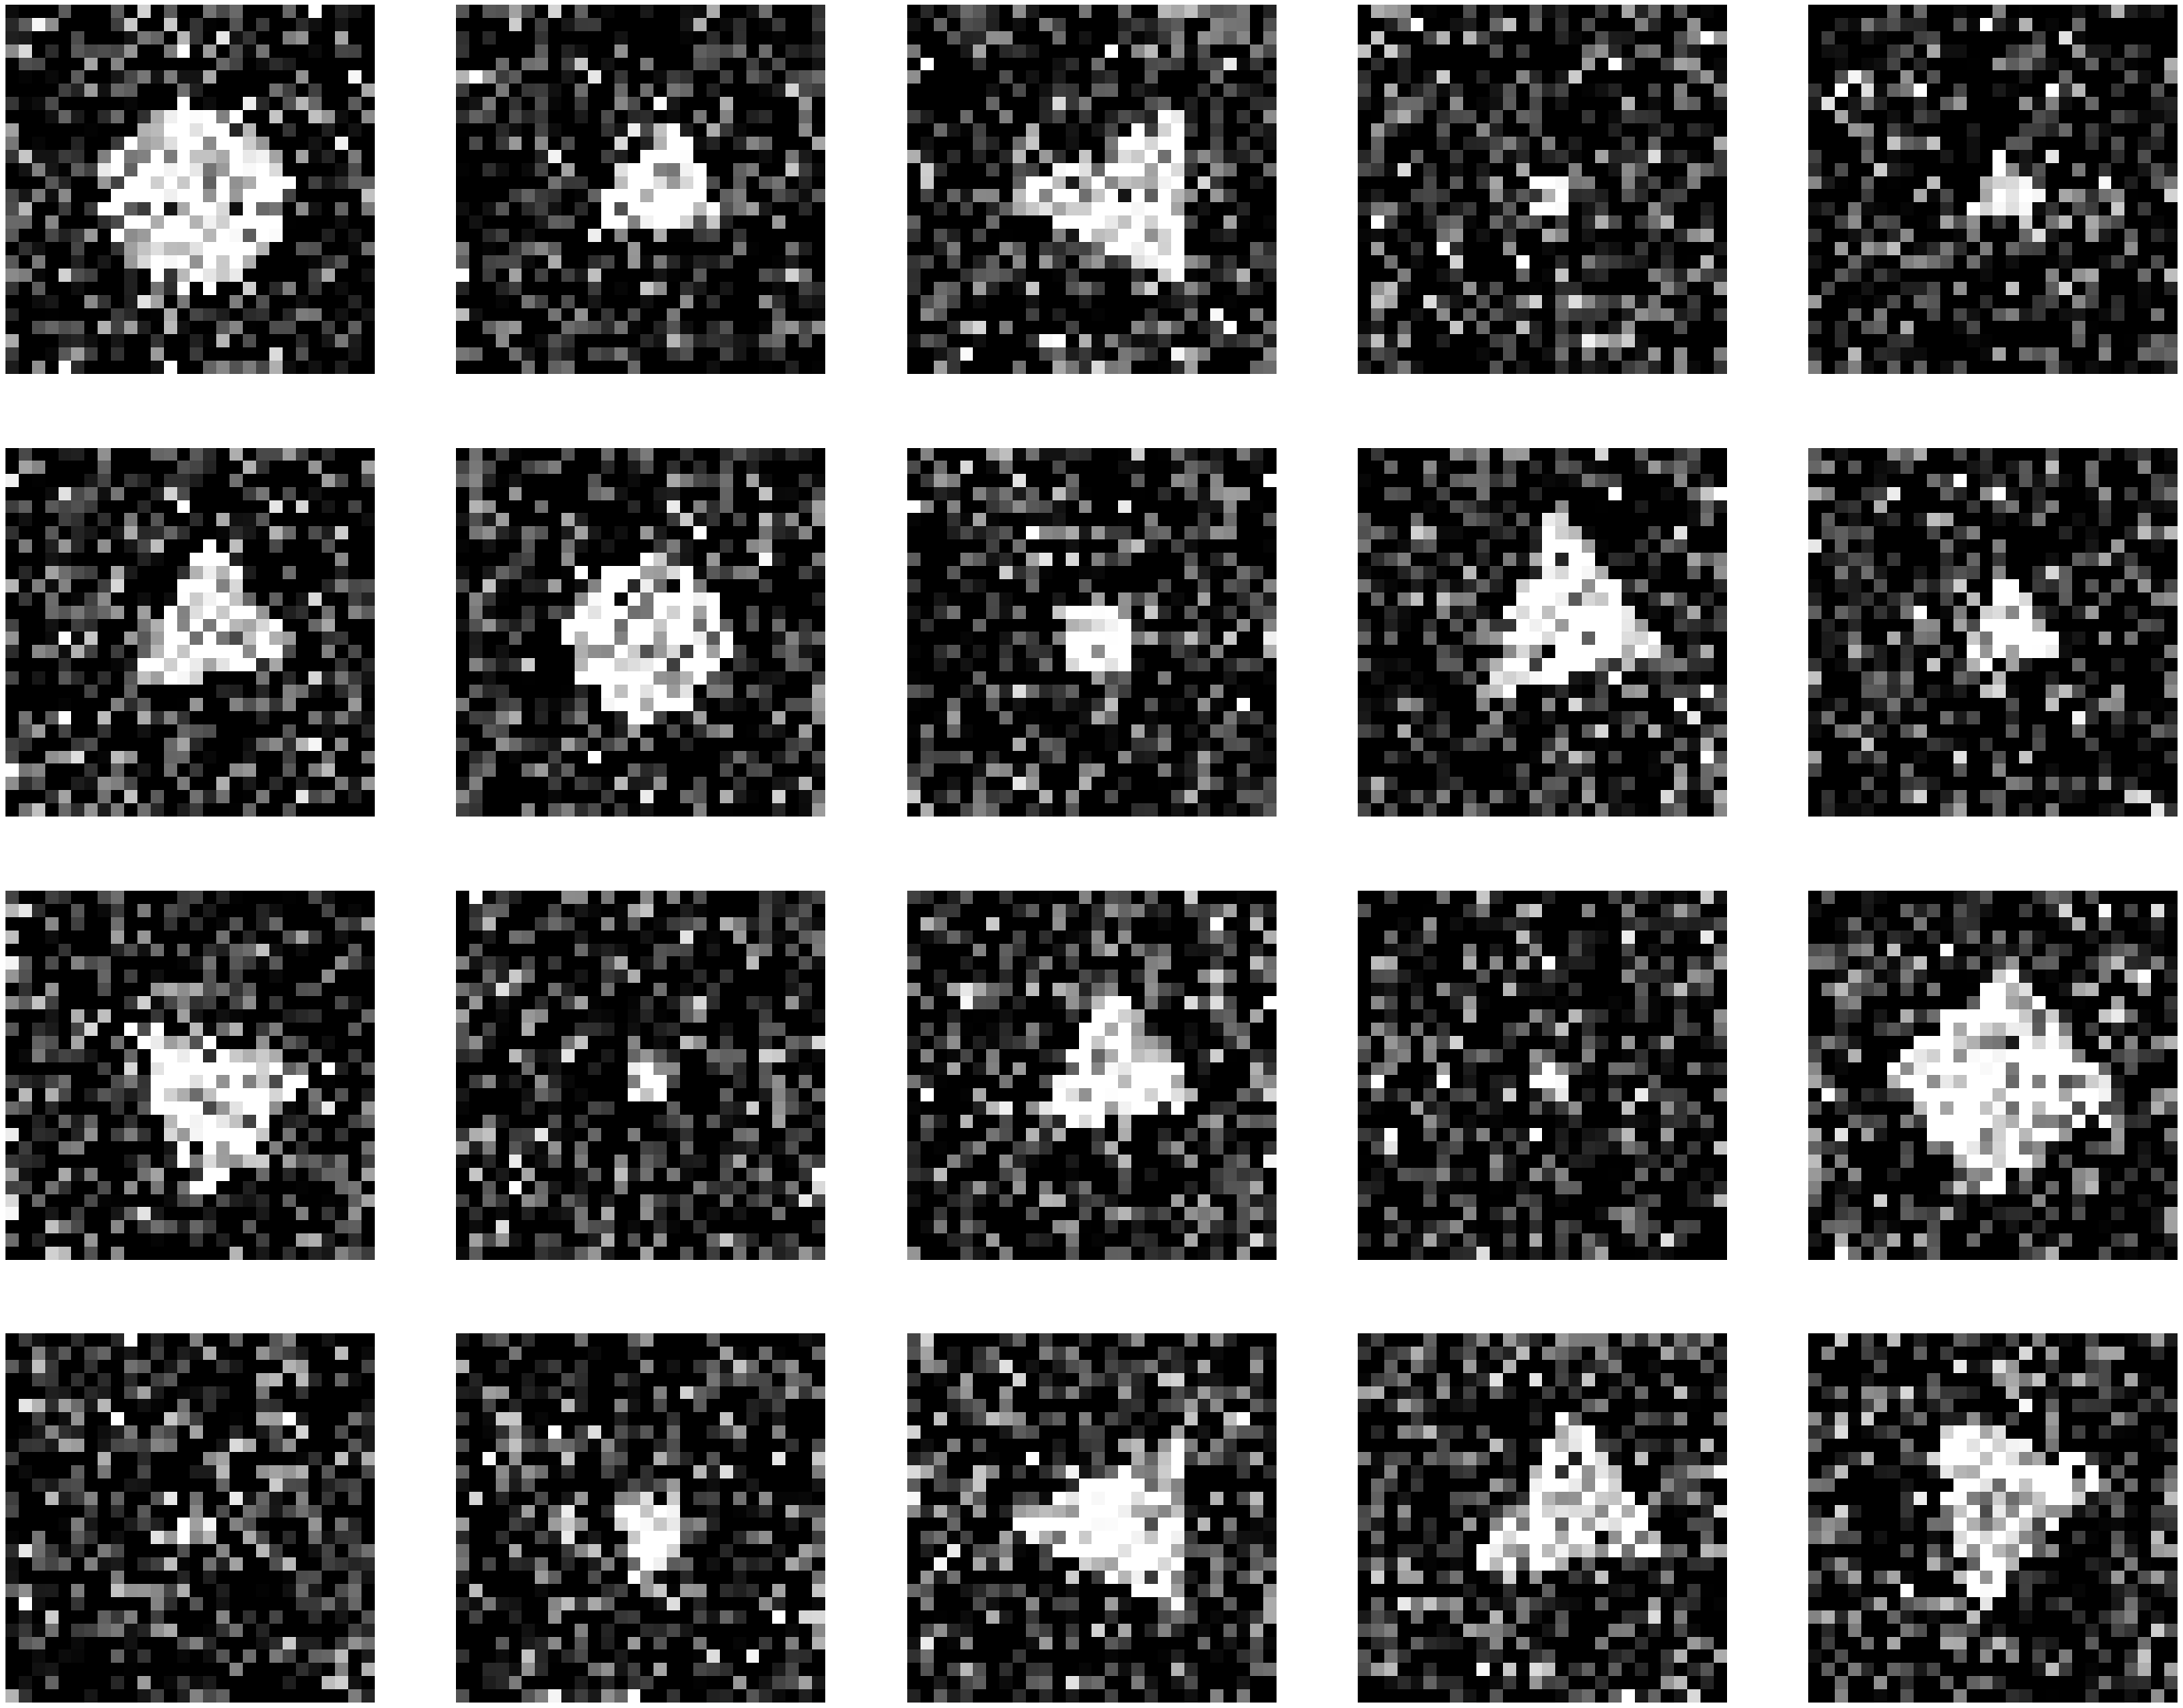

In [3]:
fig, axes = plt.subplots(4, 5, figsize=(50,40))
    
# Flatten the axes array for easier looping
axes = axes.flatten()
    
# Loop through images and axes
for i in range(20):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')  # Hide the axes for each image

Good! we have remembered how to simulate some data!


### Semantic Based-Regularization 
Lets now see how we can add some logic rules in our loss function.

We will add the following rules

* CIRCLE(x) ⇒ ¬ TRIANGLE(x) ∧ ¬ SQUARE(x)
* TRIANGLE(x) ⇒ ¬CIRCLE(x) ∧ ¬SQUARE(x)
* SQUARE(x) ⇒ ¬TRIANGLE(x) ∧ ¬CIRCLE(x)

To do that we first define the regularization term

In [15]:
def semantic_regularization_loss(logits):
    """
    Implements the semantic rule:
    CIRCLE(x) ⇒ ¬TRIANGLE(x) ∧ ¬SQUARE(x)
    TRIANGLE(x) ⇒ ¬CIRCLE(x) ∧ ¬SQUARE(x)
    SQUARE(x) ⇒ ¬TRIANGLE(x) ∧ ¬CIRCLE(x)
    """
    # Apply softmax to logits to get probabilities
    probs = F.softmax(logits, dim=1)

    # Probabilities for each class
    p_circle, p_square, p_triangle = probs[:, 0], probs[:, 1], probs[:, 2]

    # Rule: 
    violation_1 = p_circle * (p_triangle + p_square)
    violation_2 = p_triangle * (p_circle + p_square)
    violation_3 = p_square * (p_triangle + p_circle)

    reg_term = violation_1.mean() + violation_2.mean() + violation_3.mean()
    return reg_term

Now we integrate it to the train step

In [4]:
from typing import Dict, List, Tuple

def train_step_reg(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               alpha: float)-> Tuple[float, float]:
    """Trains a PyTorch model for 1 epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps 

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to help minimize the loss function.

    Returns:
        A tuple of training loss and training accuracy metrics.
        In the form (train_loss, train_accuracy)
    
  """
    model.train()
    train_loss, train_acc, train_ce= 0, 0, 0

    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Calculate standard loss
        base_loss = loss_fn(y_pred, y)
        # add regularization term
        sbr_loss = semantic_regularization_loss(y_pred)
        loss = base_loss + alpha * sbr_loss
        
        train_loss += loss    # Accumulatively add up the loss per epoch
        
        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

       # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        # Calculate Cross entropy
        train_ce += engine.cross_entropy_fn(y_true=y.detach().numpy(),
                                     y_preds=y_pred.detach().numpy()).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_ce = train_ce/ len(dataloader)
    return train_loss, train_acc, train_ce


Now, we define the training and testing loop, incorporating the regularization term into the training step

In [5]:
def train_test_loop_reg(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          print_b: True ,
          alpha= float) -> Dict[str, List]:   
    """ Train test loop by epochs.

    Conduct train test loop 

    Args:
        model: A PyTorch model to be used
        train_dataloader: A DataLoader instance for trainig the model
        test_dataloader: A DataLoader instance for testinig the model
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to minimize.
        epochs: Number of epochs to run
        print_b: Boolean. When True the epochs and the test accuracy is printed. 


    Returns:
        A list of train loss, train accuracy metrics, test loss,
        test accuracy metrics.
        In the form (train_loss, train_accuracy,test_loss, test_accuracy)
    
  """
    results = {"train_loss": [],
               "train_acc": [],
               "train_ce": [],
               "test_loss": [],
               "test_acc": [],
               "test_ce": []}
                    
    for epoch in range(epochs):
        train_loss, train_acc, train_ce = train_step_reg(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           alpha = alpha)
        
        test_loss, test_acc, test_ce = engine.test_step(model=model, dataloader=test_dataloader,
                                        loss_fn=loss_fn)

      # Print out what's happening
        if print_b:
            print(
                f"Epoch: {epoch+1} | "
                f"test_acc: {test_acc:.4f}"
            )

      # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_ce"].append(train_ce)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_ce"].append(test_ce)

    return results

Nice! now we have everything prepared to run the model. 
We will set the number of samples per class, the proportion of noisy data, 
the variance of that error and the number of replicates. 
For each data set simulated we will predict the classes using the model with no 
logical rules ($\alpha = 0$), and the model with logical constraints ($\alpha > 0$)




In [20]:
# Fix variables 
alphas = [0,0.2]

# Keep ce and test accuracy
accuracy_test = np.zeros((len(alphas)))
ce_test = np.zeros((len(alphas)))

BATCH_SIZE = 50
EPOCHS = 8

# To reduce variability when re-running 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Generate dataset
train_dataset, test_dataset = cs.generate_dataset(images, labels,seed=seed)

train_dataloader = DataLoader(train_dataset, 
                batch_size= BATCH_SIZE, 
                shuffle=False)
test_dataloader = DataLoader(test_dataset,
                batch_size= BATCH_SIZE,
                shuffle=False)


for a, alpha in enumerate(alphas):
    
    # Load model
    model = model_builder.TVGG(input_shape = 1,
                    hidden_units = 10, 
                    output_shape = 3)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
    loss_fn = nn.CrossEntropyLoss()

    # 4. Run model 
    output = train_test_loop_reg(model = model,
                                train_dataloader = train_dataloader,
                                test_dataloader = test_dataloader,
                                optimizer = optimizer,
                                loss_fn = loss_fn, 
                                epochs = EPOCHS, 
                                print_b=False,
                                alpha = alpha)
    
    accuracy_test[a]  = output['test_acc'][EPOCHS-1]  
    ce_test[a]  = output['test_ce'][EPOCHS-1]  


Lets see the results and compare

In [21]:
print('Test accuracy: ', accuracy_test)
print('Test Cross-Entropy: ', ce_test)

Test accuracy:  [87.4375 88.3125]
Test Cross-Entropy:  [3.16975729 2.13248445]
